#Import Library dan Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
base_path = '/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/'
try:
    customers_df = pd.read_csv(base_path + "customers_dataset.csv")
    print("Sukses! Path benar dan file customers terbaca.")
except FileNotFoundError:
    print("Gagal! File tidak ditemukan. Cek kembali nama folder atau path-nya.")

# Supaya output plot muncul di notebook
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sukses! Path benar dan file customers terbaca.


#Load Data

In [2]:
# --- MUAT SEMUA 9 DATASET ---

# 1. Customers
customers_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/customers_dataset.csv")

# 2. Orders
orders_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/orders_dataset.csv")

# 3. Order Items
order_items_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/order_items_dataset.csv")

# 4. Products
products_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/products_dataset.csv")

# 5. Product Category Translation
product_category_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/product_category_name_translation.csv")

# 6. Geolocation
geo_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/geolocation_dataset.csv")

# 7. Sellers (Baru)
sellers_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/sellers_dataset.csv")

# 8. Order Reviews (Baru)
order_reviews_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/order_reviews_dataset.csv")

# 9. Order Payments (Baru)
order_payments_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DicodingFundamentalAnalisisData/order_payments_dataset.csv")

print("Sempurna! Seluruh 9 dataset berhasil dimuat.")

Sempurna! Seluruh 9 dataset berhasil dimuat.


#Cek Data

In [3]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#Analisis Data



1.   Cek Data Orders

In [4]:
print("--- INFO DATA ORDERS ---")
orders_df.info()

print("\n--- MISSING VALUES ---")
print(orders_df.isna().sum())

print("\n--- DUPLICAT ---")
print("Jumlah Duplikasi:", orders_df.duplicated().sum())

--- INFO DATA ORDERS ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB

--- MISSING VALUES ---
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier

  2. Cek Data Customers & Products

In [5]:
print("--- INFO DATA CUSTOMERS ---")
customers_df.info()
print("Jumlah Duplikasi Customers:", customers_df.duplicated().sum())

print("\n" + "="*30 + "\n")

print("--- INFO DATA PRODUCTS ---")
products_df.info()
print("Missing Values Products:\n", products_df.isna().sum())
print("Jumlah Duplikasi Products:", products_df.duplicated().sum())

--- INFO DATA CUSTOMERS ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
Jumlah Duplikasi Customers: 0


--- INFO DATA PRODUCTS ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 no

  3. Cleaning data: Memperbaiki Tipe Data & Mengisi Data Kosong

In [6]:
# 1. Mengubah tipe data tanggal menjadi datetime
datetime_columns = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]

for column in datetime_columns:
    orders_df[column] = pd.to_datetime(orders_df[column])

# 2. Mengisi nama kategori produk yang kosong dengan "unknown"
products_df['product_category_name'] = products_df['product_category_name'].fillna("unknown")

# Cek hasil perbaikan
print("Tipe data order_purchase_timestamp sekarang:", orders_df['order_purchase_timestamp'].dtype)
print("Jumlah missing values di kategori produk:", products_df['product_category_name'].isna().sum())

Tipe data order_purchase_timestamp sekarang: datetime64[ns]
Jumlah missing values di kategori produk: 0


4. Menggabungkan data (merge)

In [7]:
# 1. Gabungkan Orders dengan Items (penghubung: order_id)
#    Harga (price) dari Items dan tanggal (timestamp) dari Orders
orders_items_df = pd.merge(
    left=orders_df,
    right=order_items_df,
    how="left",
    on="order_id"
)

# 2. Gabungkan hasil di atas dengan Products (penghubung: product_id)
#    mengetahui nama kategori produknya
orders_items_products_df = pd.merge(
    left=orders_items_df,
    right=products_df,
    how="left",
    on="product_id"
)

# 3. Terakhir, gabungkan dengan Customers (penghubung: customer_id)
#    Mengetahui lokasi pelanggannya
all_df = pd.merge(
    left=orders_items_products_df,
    right=customers_df,
    how="left",
    on="customer_id"
)

# Cek hasil penggabungan
print("Ukuran tabel utama (all_df):", all_df.shape)
all_df.head()

Ukuran tabel utama (all_df): (113425, 26)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,178.0,1.0,400.0,19.0,13.0,19.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,232.0,1.0,420.0,24.0,19.0,21.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,...,468.0,3.0,450.0,30.0,10.0,20.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,...,316.0,4.0,250.0,51.0,15.0,15.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


  5. Export data bersih

In [8]:
# Simpan ke CSV untuk dipakai di dashboard nanti
all_df.to_csv("all_data.csv", index=False)
print("Data berhasil diekspor ke all_data.csv!")

Data berhasil diekspor ke all_data.csv!


6. Visualisasi produk terbaik dan terburuk (Perfoma Produk)

/tmp/ipython-input-1918955776.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
/tmp/ipython-input-1918955776.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.sort_values(by="price", ascending=True).head(5), palette=colors, ax=ax[1])


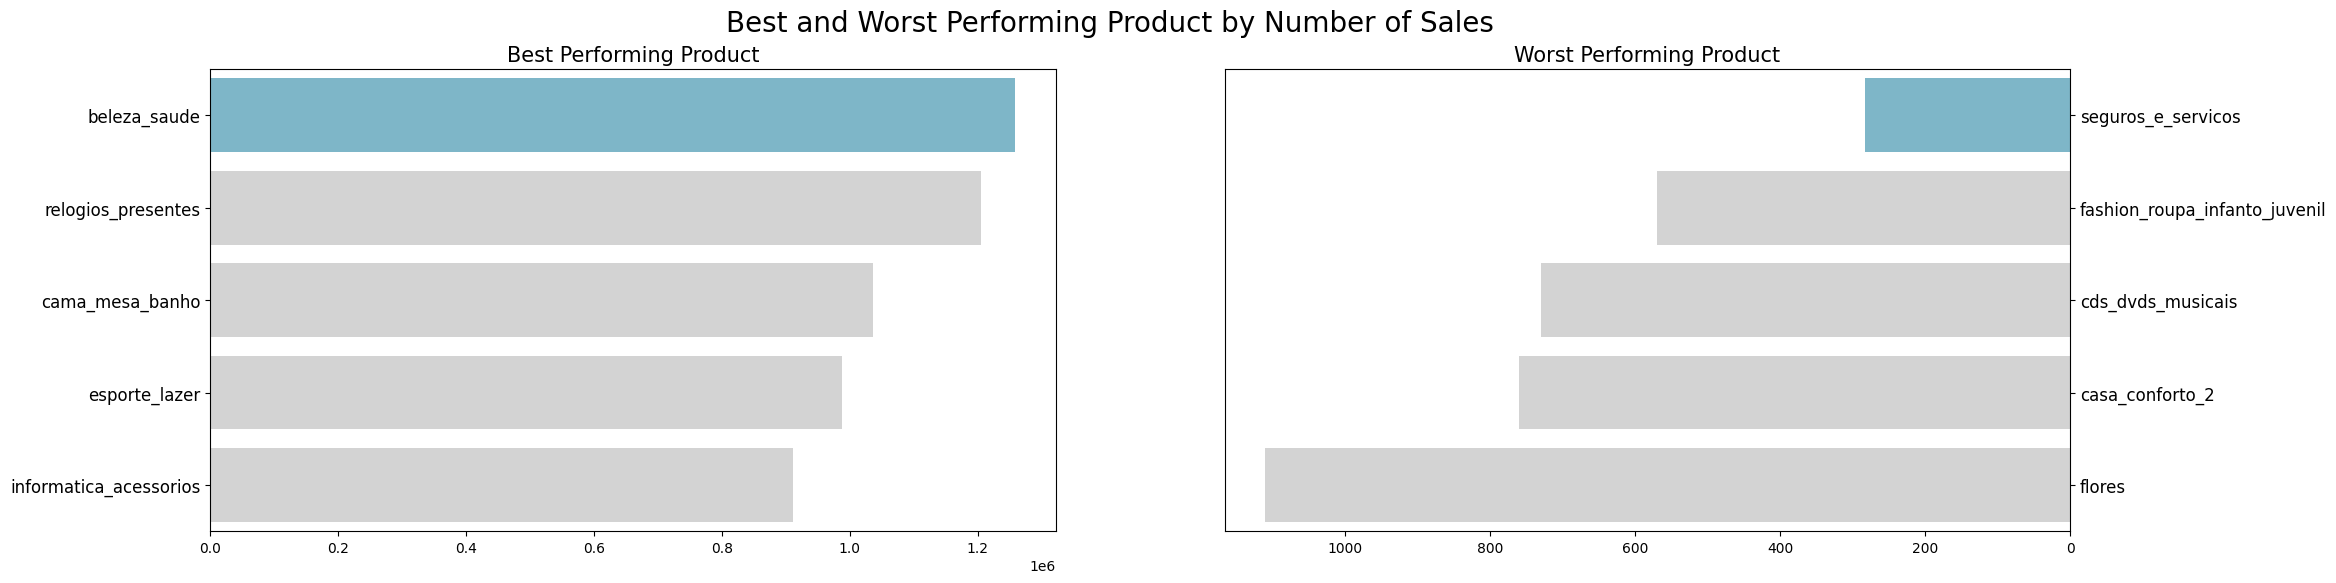

In [9]:
# Buat data agregat: hitung total penjualan (price) per kategori
sum_order_items_df = all_df.groupby("product_category_name").price.sum().sort_values(ascending=False).reset_index()

# Setup canvas untuk 2 grafik
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Warna bar chart (Hijau untuk terbaik, Merah untuk terburuk)
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

# Grafik 1: Produk Terlaris (Best Performing)
sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.head(5), palette=colors, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("Best Performing Product", loc="center", fontsize=15)
ax[0].tick_params(axis ='y', labelsize=12)

# Grafik 2: Produk Paling Sedikit Terjual (Worst Performing)
sns.barplot(x="price", y="product_category_name", data=sum_order_items_df.sort_values(by="price", ascending=True).head(5), palette=colors, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].invert_xaxis() # Membalik sumbu x supaya terlihat kontras
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=15)
ax[1].tick_params(axis='y', labelsize=12)

plt.suptitle("Best and Worst Performing Product by Number of Sales", fontsize=20)
plt.show()

7. Visualisasi Sebaran Pelanggan per Lokasi (Demografi Pelanggan)

/tmp/ipython-input-895543824.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


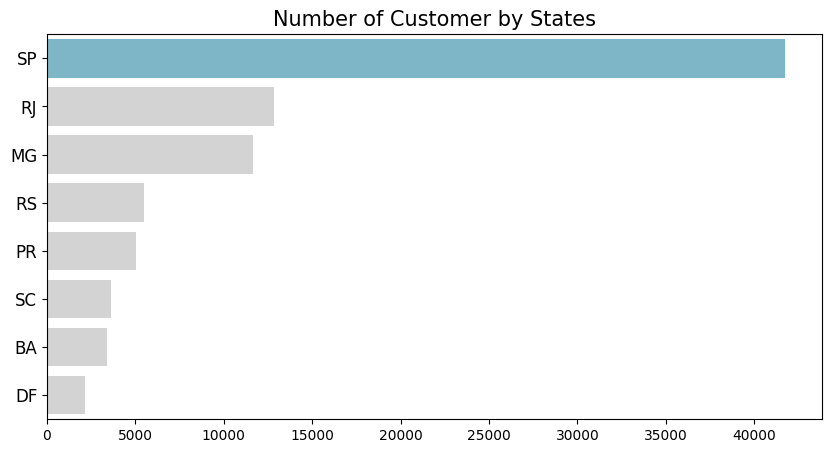

In [10]:
# Hitung jumlah customer unik per state
bystate_df = all_df.groupby(by="customer_state").customer_id.nunique().reset_index()
bystate_df.rename(columns={"customer_id": "customer_count"}, inplace=True)

# Plotting
plt.figure(figsize=(10, 5))
colors_ = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(
    x="customer_count",
    y="customer_state",
    data=bystate_df.sort_values(by="customer_count", ascending=False).head(8), # Top 8 State saja biar rapi
    palette=colors_
)
plt.title("Number of Customer by States", loc="center", fontsize=15)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='y', labelsize=12)
plt.show()

#RFM Analysis

1. Kalkulasi RFM

In [11]:
# Hitung tanggal terakhir dari data untuk jadi patokan 'sekarang'
recent_date = all_df["order_purchase_timestamp"].max().date()

# Buat RFM DataFrame
rfm_df = all_df.groupby(by="customer_unique_id", as_index=False).agg({
    "order_purchase_timestamp": "max", # Mengambil tanggal order terakhir
    "order_id": "nunique",             # Menghitung jumlah order
    "price": "sum"                     # Menghitung jumlah revenue
})

# Ganti nama kolom biar mudah dimengerti
rfm_df.columns = ["customer_id", "max_order_timestamp", "frequency", "monetary"]

# Hitung jarak hari antara tanggal terakhir order dengan tanggal patokan (recent_date)
rfm_df["max_order_timestamp"] = rfm_df["max_order_timestamp"].dt.date
rfm_df["recency"] = rfm_df["max_order_timestamp"].apply(lambda x: (recent_date - x).days)

# Hapus kolom tanggal karena sudah tidak dipakai (pakai recency angka hari)
rfm_df.drop("max_order_timestamp", axis=1, inplace=True)

# Tampilkan 5 data teratas
print(rfm_df.head())

                        customer_id  frequency  monetary  recency
0  0000366f3b9a7992bf8c76cfdf3221e2          1    129.90      160
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1     18.90      163
2  0000f46a3911fa3c0805444483337064          1     69.00      586
3  0000f6ccb0745a6a4b88665a16c9f078          1     25.99      370
4  0004aac84e0df4da2b147fca70cf8255          1    180.00      337


2. Visualisasi RFM (Plot RFM Best Customers)

/tmp/ipython-input-53605540.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
/tmp/ipython-input-53605540.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')
/tmp/ipython-input-53605540.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, horizontalalignment='right')


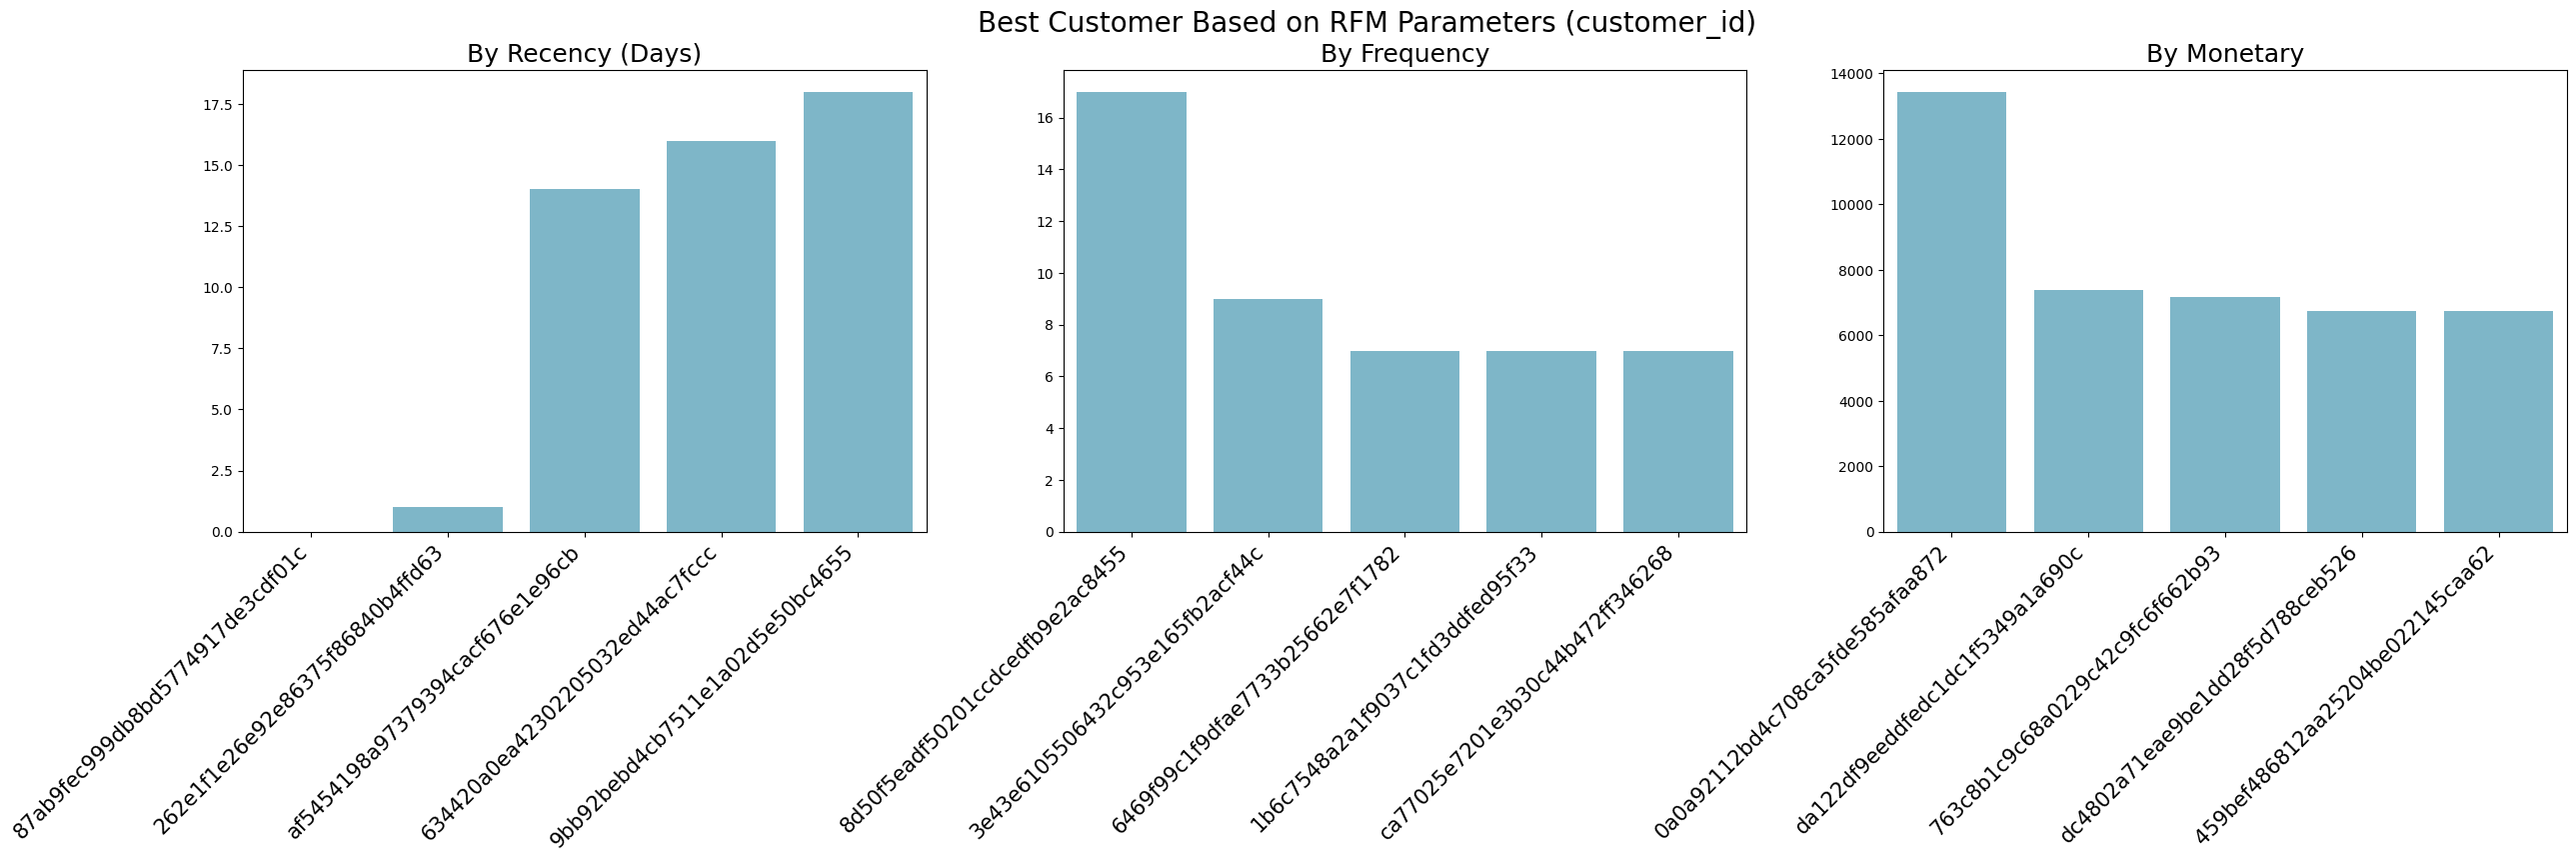

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 6))

colors = ["#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4", "#72BCD4"]

# Plot Recency (Hari terendah = terbaik)
sns.barplot(y="recency", x="customer_id", data=rfm_df.sort_values(by="recency", ascending=True).head(5), palette=colors, hue="customer_id", legend=False, ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].set_title("By Recency (Days)", loc="center", fontsize=18)
ax[0].tick_params(axis ='x', labelsize=15)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Plot Frequency (Frekuensi tertinggi = terbaik)
sns.barplot(y="frequency", x="customer_id", data=rfm_df.sort_values(by="frequency", ascending=False).head(5), palette=colors, hue="customer_id", legend=False, ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title("By Frequency", loc="center", fontsize=18)
ax[1].tick_params(axis='x', labelsize=15)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

# Plot Monetary (Uang terbanyak = terbaik)
sns.barplot(y="monetary", x="customer_id", data=rfm_df.sort_values(by="monetary", ascending=False).head(5), palette=colors, hue="customer_id", legend=False, ax=ax[2])
ax[2].set_ylabel(None)
ax[2].set_xlabel(None)
ax[2].set_title("By Monetary", loc="center", fontsize=18)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, horizontalalignment='right')

plt.suptitle("Best Customer Based on RFM Parameters (customer_id)", fontsize=20)
plt.show()